# Training a CNN on MNIST with the Partial Fenchel-Young Loss

In this example we will train a simple Conv Net on MNIST data using `jaxclust`. We will use:

- `jaxclust`: for differentiable clustering methods.
- `flax`: for our neural network class and train state.
- `optax`: for the optimizer to train our network.
- `tensorflow-datasets`: to access MNIST.

In [3]:
import sys
sys.path.append('../..')

import jax
import numpy as np
import jax.numpy as jnp
from typing import Callable, Tuple, Any
import tensorflow as tf
import jaxclust
import optax
import flax.linen as nn
from flax import core, struct
from flax.training import train_state
import optax
from functools import partial
import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

np.random.seed(0)
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

### Data loader and Model

- Using `tensorflow-datasets` we can load the train split of MNIST. 
- The function `process_nist_batch` reshapes the data to the shape required for LeNET5, as well as renormalizing the data and creating a **one-hot** representation of the labels.
- The function `next_train` takes an iterator and returns a batch $(x, y)$, and the iterator (and creates a new iterator if we reach the end of the current one).

In [4]:
import tensorflow_datasets as tfds
DSHAPE = (28, 28, 1) # shape of an image for CNN
BS = 32
DATA_DIR = '/tmp/tfds'

@jax.jit
def process_nist_batch(x, y):
    x = x.reshape((len(x), ) + DSHAPE)
    x = x / 255.
    yhot = jax.nn.one_hot(y, 10)
    return x, yhot

DS_TRAIN = tfds.load(name='mnist', batch_size=-1, data_dir=DATA_DIR, split='train', as_supervised=True)
DS_TRAIN = tf.data.Dataset.from_tensor_slices(DS_TRAIN).shuffle(buffer_size=60000, seed=0, reshuffle_each_iteration=True)
DS_TRAIN = DS_TRAIN.batch(batch_size=BS)
train_iterator = iter(tfds.as_numpy(DS_TRAIN))


def next_train(train_iterator):
    try:
        (x, y)= next(train_iterator)
        if x.shape[0] != BS:
            train_iterator = iter(tfds.as_numpy(DS_TRAIN))
            (x, y) = next(train_iterator)
    except StopIteration:
        train_iterator = iter(tfds.as_numpy(DS_TRAIN))
        (x, y)= next(train_iterator)
    
    x, y = process_nist_batch(x, y)
    return (x, y), train_iterator



2023-10-16 16:45:17.766694: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


2023-10-16 16:45:21.276731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


We begin by creating a simple CNN model in flax (this will be the model used to create our embeddings):

In [5]:
class CNN(nn.Module):
    """A simple CNN model."""
    dense1: int = 256 # size of dense layer
    dense2 : int = 256 # size of output layer

    @nn.compact
    def __call__(self, x, training=True):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=self.dense1)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.dense2)(x)
        return x


### Implementing Differentiable Clustering with JAXClust

Firstly we need to define a similarity measure. There are many choices one could take, but for now lets keep it simple and use the negative Euclidean square distance:

$$\Sigma_{i,j} = - \|x_i-x_j\|_2^2.$$


To calculate $\Sigma$ we will write the function `pairwise_square_distance` using jax:

In [6]:
def pairwise_square_distance(X):
    """
    euclidean pairwise square distance between data points
    """
    n = X.shape[0]
    G = jnp.dot(X, X.T)
    g = jnp.diag(G).reshape(n, 1)
    o = jnp.ones_like(g)
    return jnp.dot(g, o.T) + jnp.dot(o, g.T) - 2 * G


Given a similarity matrix $\Sigma$ and a number of connected components $k$, we recall the maximum weight k-connected-component forest problem:

$$A_k^*(\Sigma) = \text{argmax}_{A \in \mathcal{C}_k} \langle A, \Sigma \rangle.$$

where $A_k^*(\Sigma)$ is the adjacency matrix for the maximum weight k-connected-component forest, and $\mathcal{C}_k$ is the set of adjacency matrices which correspond to k-connected-component forests.

The maxmium weight k-connected-component forest will have weight:

$$F_k^*(\Sigma) =  \text{max}_{A \in \mathcal{C}_k} \langle A, \Sigma \rangle = \langle A_k^*(\Sigma), \Sigma \rangle.$$



To obtain a solver for this we can use `jaxclust.solvers`:


In [7]:
# flp = forest linear program
solver = jaxclust.solvers.get_flp_solver(constrained=False, use_prims=True)

Since `constrained = False`, the function `solver` will take in two arguments `Sigma` and `ncc` (the number of connected components), and returns $A^*(\Sigma)$ and $M^*(\Sigma)$. Recall that $M_k^*(\Sigma)_{ij} = 1$ if points $i$ and $j$ are in the same connected component / cluster otherwise $0$. Let's try it out on some randomly generated data:

Text(0.5, 1.0, '$M_{10}^*(\\Sigma)$')

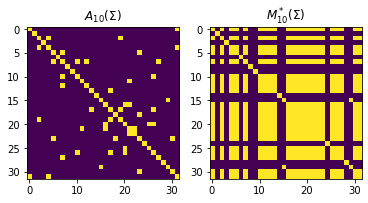

In [8]:
X = np.random.randn(BS, 3) # sample a batch of 3D data
S = - pairwise_square_distance(X) # calculate Sigma
A, M = solver(S, 10) # call the solver

fig, axs = plt.subplots(1, 2)
axs[0].imshow(A)
axs[1].imshow(M)
axs[0].set_title(r'$A_{10}(\Sigma)$')
axs[1].set_title(r'$M_{10}^*(\Sigma)$')


Similar using `jaxclust.solvers` we can call the function `get_flp_solver` but with `constrained=True` to obtain a solver that takes in partial cluster coincidence information.

 $$A_k^*(\Sigma, M_\Omega) = \text{argmax}_{A \in \mathcal{C}_k(M_\Omega)} \langle A, \Sigma \rangle\, $$

In the paper $M_\Omega$ takes values in $\{0, 1, *\}$. 

For clarity, jaxclust takes the constraints in the form of a matrix $C$ where:

- $C_{ij}=1$ implies a **must-link** constraint.
- $C_{ij}=-1$ implies a **must-not-link** constraint.
- $C_{ij}=0$ implies no constraint.

(Non-important note: if denote $*=0.5$, then $C = 2 * M_\Omega - 1$).

Once again we can call `get_flp_solver` to obtain a solver, but this time using the `constrained=True` kwarg:


In [9]:
csolver = jaxclust.solvers.get_flp_solver(constrained=True, use_prims=True)

Now we have a unconstrained solver `solver`, and a constrained solver `csolver`, we can use the `jaxclust.perturbations` module to create their smooth proxies in order to obtain gradients for training.

The perturbed proxies are defined as:

$$A_{k,\epsilon}^*(\Sigma) = \mathbb{E}_Z\left[\text{argmax}_{A \in \mathcal{C}_k} \langle A, \Sigma + \epsilon Z \rangle\right].$$


 $$A_{k,\epsilon}^*(\Sigma, M_\Omega) =\mathbb{E}_Z\left[ \text{argmax}_{A \in \mathcal{C}_k(M_\Omega)} \langle A, \Sigma + \epsilon Z\rangle\, \right]. $$

$$F_{k,\epsilon}^*(\Sigma) = \mathbb{E}_Z\left[\text{max}_{A \in \mathcal{C}_k} \langle A, \Sigma + \epsilon Z \rangle\right].$$

 $$F_{k,\epsilon}^*(\Sigma, M_\Omega) =\mathbb{E}_Z\left[ \text{max}_{A \in \mathcal{C}_k(M_\Omega)} \langle A, \Sigma + \epsilon Z\rangle\, \right]. $$



We can obtain a solver that returns $(A^*_{k,\epsilon} , F^*_{k, \epsilon}, M^*_{k, \epsilon})$ by using the function `make_pert_flp_solver` found in the `jaxclust.perturbations` module, for both constrained and unconstrained solvers:


In [10]:
NUM_SAMPLES = 100
SIGMA = 0.1

pert_solver = jaxclust.perturbations.make_pert_flp_solver(solver,
                                                          constrained=False,
                                                          num_samples=NUM_SAMPLES,
                                                          sigma=SIGMA)

pert_csolver = jaxclust.perturbations.make_pert_flp_solver(csolver,
                                                           constrained=True,
                                                           num_samples=NUM_SAMPLES,
                                                           sigma=SIGMA)



We can now implement the whole differentiable clustering pipeline as a `flax.linen.Module`.

We define a dataclass called `DC` (differentiable clustering), which takes in:

- `backbone` : This will be the model used to produce the embeddings, say for example our CNN we previously define.
- `pert_solver` : The unconstrained perturbed solver.
- `pert_csolver` : The constrained perturbed solver.

The forward pass calculates the Partial Fenchel-Young loss:

$\ell(\Sigma, M_\Omega) = F_{k,\epsilon}^*(\Sigma) - F_{k,\epsilon}^*(\Sigma, M_\Omega)$

whose gradient will be $\nabla_\Sigma \ell = A_{k, \epsilon}^*(\Sigma) - A_{k, \epsilon}^*(\Sigma, M_\Omega)$:

In [11]:
class DC(nn.Module):
    '''
    supervised differentiable clustering
    '''
    backbone : nn.Module # model backbone used to create embeddings
    pert_solver : Callable # perturbed clustering
    pert_csolver : Callable # perturbed constrained clustering

    # call is equivalent to embedding the data
    @nn.compact
    def __call__(self, *args, **kwargs):
        return self.backbone(*args, **kwargs)

    def similarity(self, Z):
        S =  -pairwise_square_distance(Z)
        # standardizing reduces dependence of sigma on x
        S = (S - S.mean()) / S.std()
        return S

    def forward(self, x, yhot, ncc, key, training=True):
        Z = self.__call__(x, training=training)
        S = self.similarity(Z)
        M_target = yhot @ yhot.T
        C = 2 * M_target - 1

        Ak, Fk, Mk = self.pert_solver(S, ncc, key)
        Akc, Fkc, Mkc = self.pert_csolver(S, ncc, C, key)

        partial_fy_loss = Fk - Fkc
        return partial_fy_loss


In line with `flax`, we will define a train state which encapsulates all parameters (model and optimizer) and methods required for training / evaluation:

In [12]:
class DCTrainState(struct.PyTreeNode):
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    forward_fn: Callable = struct.field(pytree_node=False)
    params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    tx: optax.GradientTransformation = struct.field(pytree_node=False)
    opt_state: optax.OptState = struct.field(pytree_node=True)

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(
            grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)
        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            **kwargs,
        )

    @classmethod
    def create(cls, *, apply_fn, forward_fn, params, tx, **kwargs):
        opt_state = tx.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            forward_fn=partial(apply_fn, method=forward_fn),
            params=params,
            tx=tx,
            opt_state=opt_state,
            **kwargs,
        )

Let us instantiate our model and optimizer:

In [13]:
optimizer = optax.adamw(3e-4, weight_decay=1e-4)

model = DC(
    CNN(),
    pert_solver=pert_solver,
    pert_csolver=pert_csolver)

In [14]:
dummy_x = jnp.ones((BS, ) + (DSHAPE))
params = model.init({'params' : jax.random.PRNGKey(0)}, dummy_x, training=True)['params']


In [15]:
from clu import parameter_overview
print(parameter_overview.get_parameter_overview(params))


+-------------------------+----------------+---------+-----------+--------+
| Name                    | Shape          | Size    | Mean      | Std    |
+-------------------------+----------------+---------+-----------+--------+
| backbone/Conv_0/bias    | (32,)          | 32      | 0.0       | 0.0    |
| backbone/Conv_0/kernel  | (3, 3, 1, 32)  | 288     | 0.0223    | 0.342  |
| backbone/Conv_1/bias    | (64,)          | 64      | 0.0       | 0.0    |
| backbone/Conv_1/kernel  | (3, 3, 32, 64) | 18,432  | -0.000226 | 0.0587 |
| backbone/Dense_0/bias   | (256,)         | 256     | 0.0       | 0.0    |
| backbone/Dense_0/kernel | (3136, 256)    | 802,816 | -1.17e-05 | 0.0178 |
| backbone/Dense_1/bias   | (256,)         | 256     | 0.0       | 0.0    |
| backbone/Dense_1/kernel | (256, 256)     | 65,536  | -9.22e-05 | 0.0625 |
+-------------------------+----------------+---------+-----------+--------+
Total: 887,680


In [16]:
state = DCTrainState.create(
    apply_fn=model.apply,
    forward_fn=model.forward,
    params = params,
    tx = optimizer
)

We can now make a function that performs a single training step given a batch of data. This is `jax.jit` compatible.

In [17]:
@jax.jit
def train_step_fn(state, X, Yhot, ncc, rngs):
    def forward(params, X, Yhot, ncc, rngs):
        return state.forward_fn({'params' : params}, X, Yhot, ncc, rngs['noise'], True, rngs=rngs)
    loss, grads = jax.value_and_grad(forward)(state.params, X, Yhot, ncc, rngs)
    state = state.apply_gradients(grads=grads)
    return state, loss, grads

We can use the above function to perform a training loop in just a few lines of code:

In [18]:
NSTEPS = 300
rngs = {'noise' : jax.random.PRNGKey(0)}

losses = []
for i in tqdm.tqdm(range(NSTEPS)):
      rngs = {k : jax.random.fold_in(v, i) for (k, v) in rngs.items()}
      (X, Yhot), train_iterator = next_train(train_iterator)
      state, pl, grads = train_step_fn(state, X, Yhot, 10, rngs)
      losses.append(pl.item())


100%|██████████| 300/300 [00:49<00:00,  6.03it/s]


Plotting the partial Fenchel-Young loss throughout training with and without smoothing:

Text(0, 0.5, 'Partial FY Loss')

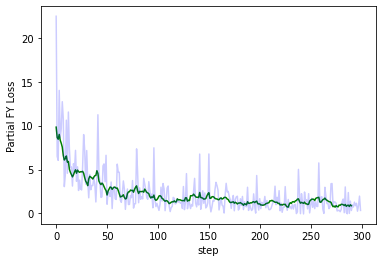

In [19]:
import matplotlib.pyplot as plt
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(losses, 10), color='g', label='moving average')
plt.plot(losses, color='b', alpha=0.2, label='raw')
plt.xlabel('step')
plt.ylabel('Partial FY Loss')


Perform a tSNE visualization of the model embeddings for some of the dataset:

In [20]:
NTSNE = 3000
X, Y = tfds.load(name='mnist', batch_size=-1, data_dir=DATA_DIR, split='train', as_supervised=True)
X = np.array(X)
Y = np.array(Y)

X = X[:NTSNE].reshape(-1, 28, 28, 1) / 255.0
Y = Y[:NTSNE].astype('int')

In [21]:
from sklearn.manifold import TSNE
V = state.apply_fn({'params' : state.params}, X)
tsne = TSNE(n_components=2).fit_transform(V)


/Users/lawrencestewart/miniconda3/envs/m1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lawrencestewart/miniconda3/envs/m1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


([], [])

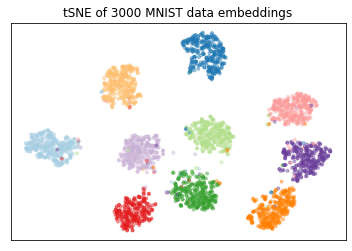

In [22]:
TSNE_COLORS = [
    '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f',
    '#ff7f00','#cab2d6','#6a3d9a',
]

color_map = np.array([TSNE_COLORS[i] for i in range(10)])

plt.scatter(tsne[:, 0], tsne[:, 1], color=color_map[Y], marker='.', alpha=0.4)
plt.title(f'tSNE of {NTSNE} MNIST data embeddings')
plt.xticks([])
plt.yticks([])

The differentiable clustering methodology comes from the following paper:

**[Stewart et al. 2023]** -  Differentiable Clustering with Perturbed Random Forests, *Advances in Neural Information Processing Systems 2023.*

